In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [114]:
# libraries to build algorithm
import sys
import numpy as np
from numpy import linalg as la
from functools import reduce
# libraries to import data
from sklearn.datasets import make_moons, make_blobs
# libraries for plotting
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# libraries for in-built algorithm
from sklearn import covariance

In [102]:
# custom classes and functions
sys.path.append('..')
from utils.plotting import plot_classification_data
from utils.metrics import classification_report

## Load data

In [105]:
X.shape, X_test.shape, y.shape, y_test.shape

((400, 2), (110, 2), (400, 2), (110, 2))

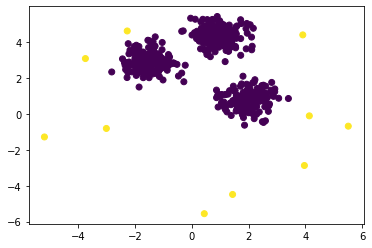

In [108]:
X, __ = make_blobs(cluster_std=0.5, n_samples=500, n_features=2, random_state=0)
np.random.shuffle(X)
X_test = X[:100, :]
X = X[100:, :]
outliers = np.random.uniform(low=-6, high=6, size=(10, 2))
y = np.zeros((X.shape[0],))
y_test = np.concatenate((np.zeros((X_test.shape[0],)), np.ones((outliers.shape[0],))))
X_test = np.concatenate((X_test, outliers), axis=0)
plot_classification_data(np.concatenate((X, X_test)), np.concatenate((y, y_test)))

## Algorithm

In [111]:
class AnomalyDetection():
    def __init__(self, method = 'univariate'):
        self.method = method
        self.mean_ = None
        self.std_ = None
        self.cov_det_ = None
        self.cov_inv_ = None
        self.n_ = None
        
    def univariate_gaussian(self, x):
        prob = ( 1 / (np.sqrt(np.pi)*self.std_) ) * np.exp( - np.power(x - self.mean_,2) / (2 * np.power(self.std_,2)) )
        return np.product(prob, axis = 1)
    
    def multivariate_gaussian(self, x):
        a = 1 / (np.power(np.pi, self.n_/2) * np.sqrt(self.cov_det_))
        x_centered = x - self.mean_
        mahalanobis_dist = np.sqrt( np.sum( np.matmul(x_centered, self.cov_inv_) * x_centered, axis=1 ) ) # m,1
        b = 1 / np.exp(mahalanobis_dist) 
        return a * b
    
    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        if self.method == 'univariate': 
            self.std_ = np.std(X, axis=0)
        else:
            self.n_ = X.shape[1]
            x_cov = np.matmul(X.T, X)
            self.cov_det_ = la.det(x_cov)
            self.cov_inv_ = la.inv(x_cov)
            
    def predict(self, X_test, epsilon = 0.01, pred_prob =  False):
        if self.method == 'univariate':
            prob = self.univariate_gaussian(X_test)
        else:
            prob = self.multivariate_gaussian(X_test)
        if not pred_prob or epsilon is None:
            prob = (prob <= epsilon).astype(int)
        return prob

## Apply algorithm

In [121]:
uni_ad = AnomalyDetection(method = 'univariate')
uni_ad.fit(X)
y_pred = uni_ad.predict(X_test, epsilon = 0.005)

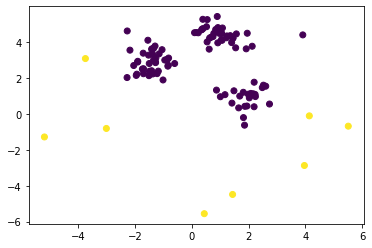

In [122]:
plot_classification_data(X_test, y_pred)

In [123]:
multi_ad = AnomalyDetection(method = 'univariate')
multi_ad.fit(X)
y_pred = multi_ad.predict(X_test, epsilon = 0.005)

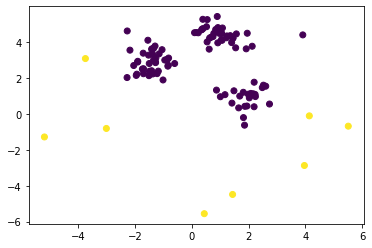

In [124]:
plot_classification_data(X_test, y_pred)

## Compare with in-built algorithm

In [131]:
ad2 = covariance.EllipticEnvelope(contamination=0.005)
ad2.fit(X)
y_pred2 = ad2.predict(X_test)

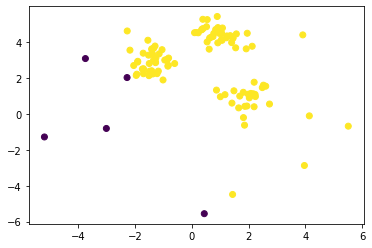

In [132]:
plot_classification_data(X_test, y_pred2)